## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from sklearn.cluster import KMeans
from variaIa.variaIa import baserate
from variaIa.variaIa import stretchevol
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys, $z[:z_{\text{max}}]$, $x_1[:z_{\text{max}}]$, mean, std et données totales

In [3]:
d = pd.read_csv('../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

surv = {'SNF':  d_snf,
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

with open('../Data/zmax_result', 'rb') as f:
    z_lins, meds, stds, z_max = pickle.load(f)

z_max['SNF'] = [10, 10, 10]
z_max['HST'] = [10, 10, 10]

colors = {'SNF': 'orange',
          'SDSS': 'lime',
          'PS1': 'blue',
          'SNLS': 'red',
          'HST': 'purple'}

zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()
x1_err_zcuts = dict()

for survey in surveys[1:]:
    zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][1])
    z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
    x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
    x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    
zmax_cuts['SNF'] = np.where(surv['SNF']['host.zcmb'].values < z_max['SNF'][1])
z_zcuts['SNF'] = surv['SNF']['host.zcmb'].values[zmax_cuts['SNF']]
x1_zcuts['SNF'] = surv['SNF']['salt2.X1'].values[zmax_cuts['SNF']]
x1_err_zcuts['SNF'] = surv['SNF']['salt2.X1.err'].values[zmax_cuts['SNF']]

datax_all = np.concatenate(
    (np.concatenate(
        (np.concatenate(
            (np.concatenate((x1_zcuts['SNF'],
                             x1_zcuts['SDSS'])),
             x1_zcuts['PS1'])),
         x1_zcuts['SNLS'])),
     x1_zcuts['HST']))
                                                     
datax_err_all = np.concatenate(
    (np.concatenate(
        (np.concatenate(
            (np.concatenate((x1_err_zcuts['SNF'],
                             x1_err_zcuts['SDSS'])),
             x1_err_zcuts['PS1'])),
         x1_err_zcuts['SNLS'])),
     x1_err_zcuts['HST']))
                                                     
dataz_all = np.concatenate(
    (np.concatenate(
        (np.concatenate(
            (np.concatenate((z_zcuts['SNF'],
                             z_zcuts['SDSS'])),
             z_zcuts['PS1'])),
         z_zcuts['SNLS'])),
     z_zcuts['HST']))

## Number of data for each survey and total

In [4]:
for survey in surveys:
    print(r'N(' + survey + ') = ', len(z_zcuts[survey]))

print(r'N(total) = ', np.sum([len(z_zcuts[survey]) for survey in surveys]))

N(SNF) =  141
N(SDSS) =  191
N(PS1) =  164
N(SNLS) =  121
N(HST) =  26
N(total) =  643


## Utilisation de la classe _stretchevol_ pour le fit double total

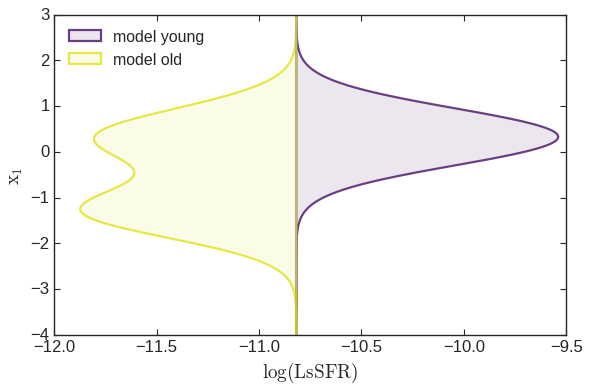

In [6]:
reload(stretchevol)

evol3G2M2S = stretchevol.Evol3G2M2S()
evol3G2M2S.set_data(dataz_all, datax_all, datax_err_all)

evol3G2M2S.GUESSVAL[3] = -1

evol3G2M2S.minimize()

evol3G2M2S.plotter()

#fig=plt.gcf()
#fig.savefig('/home/nora/Pictures/BiGaussian.pdf')

## Défnition _age-law_

In [30]:
res_SNF

{'a': 0.47715121395809157,
 'mu_1': 0.3868646937414961,
 'sigma_1': 0.555465859117784,
 'mu_2': -1.5209713725396492,
 'sigma_2': 0.5187834441554329}

In [37]:
def delta(z):
    return stretchevol.MockEvol().delta(z)

with open('../Data/SNF_results', 'rb') as f:
    res_SNF = pickle.load(f)

def age_law_snf(z):
    """Analytical law with snf results"""
    return (delta(z)*res_SNF['mu_1'] + (1-delta(z))*(res_SNF['a']*res_SNF['mu_1'] + 
                                                 (1-res_SNF['a'])*res_SNF['mu_2']))
    #return delta(z)*0.3869 + (1-delta(z))*(0.4772*0.3869 + (1-0.4772)*-1.5210)

def age_law_all(z):
    """Analytical law with 3G2M2S results"""
    return (delta(z)*evol3G2M2S.param['mu_1']
      + (1-delta(z))*(evol3G2M2S.param['a']*evol3G2M2S.param['mu_1']
              + (1 - evol3G2M2S.param['a'])*evol3G2M2S.param['mu_2']))

def age_law_gen(z, param_hesse):
    """Function to get laws with parameters taken wrt there hesse error"""
    return (delta(z)*param_hesse[1]
      + (1-delta(z))*(param_hesse[0]*param_hesse[1]
              + (1 - param_hesse[0])*param_hesse[2]))

## Définition de _cov_ pour sélection aléatoire des paramètres

In [12]:
cov = im.Minuit.matrix(evol3G2M2S.m_tot)
mean = [evol3G2M2S.m_tot.values[i] for i in range(5)]
param_hesse_mat = scipy.stats.multivariate_normal.rvs(mean=mean, cov=cov, size=500)

In [14]:
cov

---------------------------------------------------------------
|         |         a      mu_1   sigma_1      mu_2   sigma_2 |
---------------------------------------------------------------
|       a |  0.281E-1 -0.123E-1  0.069E-1 -0.388E-1 -0.170E-1 |
|    mu_1 | -0.123E-1  0.066E-1 -0.033E-1  0.176E-1  0.075E-1 |
| sigma_1 |  0.069E-1 -0.033E-1  0.025E-1 -0.096E-1 -0.039E-1 |
|    mu_2 | -0.388E-1  0.176E-1 -0.096E-1  0.612E-1  0.262E-1 |
| sigma_2 | -0.170E-1  0.075E-1 -0.039E-1  0.262E-1  0.144E-1 |
---------------------------------------------------------------

### Only take _a_, _µ1_ and _µ2_

In [13]:
param_hesse_cut = param_hesse_mat[:,[0,1,3]]

### List of all the models

In [16]:
zlin = np.linspace(0, 2.65, 1000)
models_hesse = [[age_law_gen(zi, param_hesse) for zi in zlin] for param_hesse in param_hesse_cut]
models_hesse = np.asarray(models_hesse)

### Take _std_

In [17]:
models_std = np.std(models_hesse, axis=0)

## Utilisation du _mock_ sur large bande de redshifts

In [9]:
#evol3G2M2S.param['sigma_2'] = evol3G2M2S.param['sigma_1']

def get_stretch_sample(redshift, npoints, shuffle=True):
    mock = stretchevol.MockEvol()
    mock.set_values(evol3G2M2S.param)
    mock.set_data(redshift, npoints)
    mock.solver()
    mockx = np.concatenate((mock.x1_o,mock.x1_y))
    if shuffle:
        np.random.shuffle(mockx)
    return mockx

In [10]:
zz = np.linspace(0, 2.65, 200)
x1_z = np.asarray([get_stretch_sample(z_, 100000) for z_ in zz])

low_x1 = np.asarray([len(x_[x_<-.5])/len(x_) for x_ in x1_z])

## Moyennage sur toutes les données pour plus de points

### Définition des bins sur lesquels faire les moyennes

In [18]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

n, bins, patches = plt.hist(dataz_all, histedges_equalN(dataz_all, 6))
plt.close()

### Tracé des points

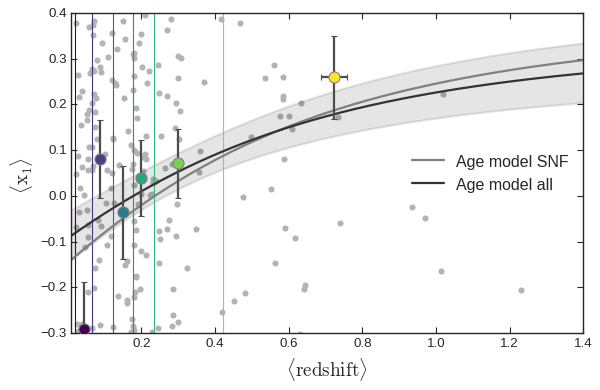

In [38]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop = dict(marker="o", ms=10, ecolor="0.3", lw=2, mew=1, mec="0.5", zorder=5)

ax.scatter(dataz_all, datax_all, color="0.7")

vmap_v = plt.cm.viridis(np.linspace(0, 1, len(bins)))
for i in range(len(bins)):
    ax.vline(bins[i], color = vmap_v[i])

slices = []
x1_comp_mean = np.zeros(6)
x1_comp_std = np.zeros(6)
z_comp_mean = np.zeros(6)
z_comp_std = np.zeros(6)

for i in range(6):
    slices.append(np.where((dataz_all > bins[i]) & (dataz_all <= bins[i+1])))
    x1_comp_mean[i] = np.mean(datax_all[slices[i]])
    x1_comp_std[i] = np.std(datax_all[slices[i]])
    z_comp_mean[i] = np.mean(dataz_all[slices[i]])
    z_comp_std[i] = np.std(dataz_all[slices[i]])
    
vmap_s = plt.cm.viridis(np.linspace(0, 1, 6))
for i, c in zip(range(6), vmap_s):
   ax.errorbar(z_comp_mean[i], x1_comp_mean[i],
               xerr = z_comp_std[i]/np.sqrt(len(dataz_all[slices[i]])),
               yerr = x1_comp_std[i]/np.sqrt(len(dataz_all[slices[i]])),
               color=vmap_s[i], **prop)

#ax.plot(zz, np.mean(x1_z, axis=1),
#        color="0.5", lw=2, zorder=2, label="Age mock all")
#ax.plot(zz_all, np.mean(x1_z_all, axis=1), color="0.7", zorder=2, label="Age model all")

ax.plot(zlin, age_law_snf(zlin),
        color="0.5", lw=2,
        label='Age model SNF')

ax.plot(zlin, age_law_all(zlin),
        color="0.2", lw=2,
        label='Age model all')

ax.fill_between(zlin, age_law_all(zlin) + models_std,
                age_law_all(zlin) - models_std,
                color="0", alpha=.1, lw=2)

ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 12,
               top = True, right = True)

ax.set_xlabel(r"$\langle\mathrm{redshift} \rangle$ ", fontsize="x-large")
ax.set_ylabel(r"$\langle\mathrm{x}_1 \rangle$ ", fontsize="x-large")

plt.legend(ncol=1, loc='center right')

#ax.set_ylim(-3, 3)
ax.set_ylim(-0.3, 0.4)
ax.set_xlim(0.01, 1.4)
#ax.set_xscale('log')

fig=plt.gcf()
#fig.savefig('/home/nora/Documents/Thèse/Images/stretchevol_all_vs_snf_update.pdf')